In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pyh5md
import scipy.signal
from glob import glob
import itertools
from matplotlib.figure import SubplotParams
from scipy.optimize import leastsq
from scipy.integrate import cumtrapz
import tidynamics

plt.rcParams['figure.figsize'] = (5.6, 4.2)
plt.rcParams['figure.subplot.hspace'] = .25
plt.rcParams['figure.subplot.wspace'] = .3
plt.rcParams['figure.subplot.left'] = .24
plt.rcParams['figure.subplot.bottom'] = .15
plt.rcParams['figure.subplot.top'] = 0.95
plt.rcParams['figure.subplot.right'] = 0.95

plt.rcParams['font.size'] = 16

π = np.pi

In [2]:
# Collect all simulation data in store

EPSB = '05.00'

sp_runs = glob('/path/to/active/l/with/{EPSB}/janus.h5'.format(EPSB=EPSB))

sp_runs.sort()
print(len(sp_runs), 'runs found')

12 runs found


In [3]:
# For comparison, also list the equilibrium runs

eq_runs = glob('/path/to/equilibrium/l/with/{EPSB}/*/janus.h5'.format(EPSB=EPSB))
eq_runs.sort()

print(len(eq_runs), 'runs found')


24 runs found


In [4]:
radius_data = []
v_mean = []

for r in sp_runs:
    with pyh5md.File(r, 'r') as a:

        L = a['particles/janus/box/edges'][:]

        obs = a['observables']
        el = pyh5md.element(obs, 'omega_body')
        omega_body_dt = el.time
        omega_body = el.value[::4]
        el = pyh5md.element(obs, 'janus_pos')
        com_pos_dt = el.time
        com_pos = el.value[::4]
        el = pyh5md.element(obs, 'janus_vel')
        com_vel_dt = el.time
        com_vel = el.value[::4]

        janus = a['particles/janus']
        pos_0 = pyh5md.element(janus, 'position').value[0]
        el = pyh5md.element(janus, 'position')
        pos_dt = el.time
        pos = el.value[:]
        el = pyh5md.element(janus, 'image')
        im = el.value[:]
        im_dt = el.time
        pos += im*L

        # Define the direction of the long and short arms of the L

        idx_1, idx_2 = 5, 35
        d_20_0 = np.sqrt(np.sum((pos_0[idx_2]-pos_0[0])**2))
        u_perp = (pos[:,idx_2,:]-pos[:,0,:])/d_20_0

        d_4_0 = np.sqrt(np.sum((pos_0[idx_1]-pos_0[0])**2))
        u_para = (pos[:,idx_1,:]-pos[:,0,:])/d_4_0

        v_1 = np.sum(com_vel*u_perp, axis=1)
        v_2 = np.sum(com_vel*u_para, axis=1)
        v_3 = omega_body[:,1]
        
        radius_data.append(v_1.mean()/v_3.mean())
        v_mean.append((v_1.mean(), v_2.mean(), v_3.mean()))

v_mean = np.array(v_mean)


<IPython.core.display.Javascript object>


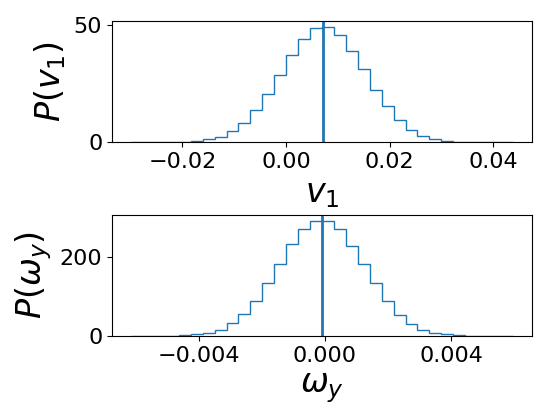

In [5]:
# plot velocity and angular velocity distributions

params = SubplotParams(left=0.2, bottom=0.2, hspace=0.6)
plt.figure(subplotpars=params)

plt.subplot(211)

plt.hist(v_1, bins=32, normed=True, histtype='step');
plt.axvline(v_1.mean(), lw=2);

x_max = np.max(np.abs(plt.xlim()))

plt.xlabel(r'$v_1$', fontsize=24)
plt.ylabel(r'$P(v_1)$', fontsize=24)

plt.subplot(212)

plt.hist(v_3, bins=32, normed=True, histtype='step');
plt.axvline(v_3.mean(), lw=2);

plt.xticks(np.linspace(-0.004, 0.004, 3))

plt.xlabel(r'$\omega_y$', fontsize=24)
plt.ylabel(r'$P(\omega_y)$', fontsize=24)

plt.savefig('L_hist_v1_omega.pdf')

In [6]:
print("Radius", np.mean(radius_data), "+/-", np.std(radius_data))

Radius -73.0365037971 +/- 7.7093705772


<IPython.core.display.Javascript object>


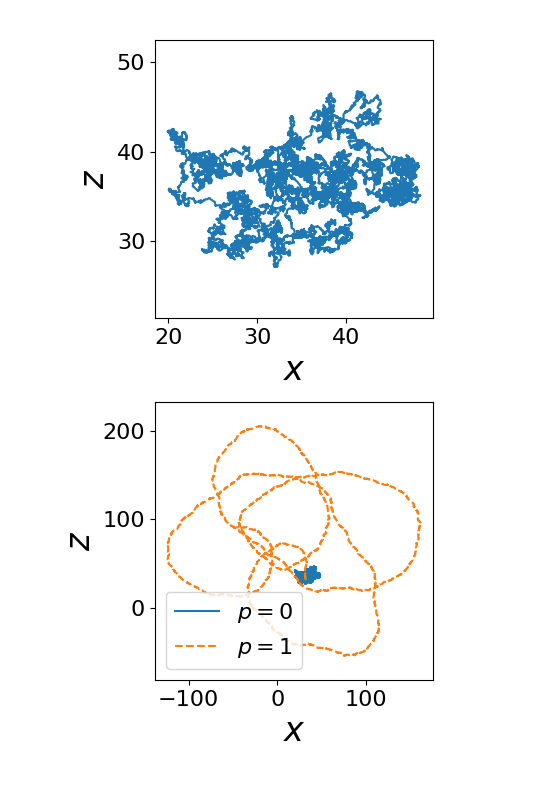

In [7]:
# plot equilibrium and self-propelled example trajectories

params = SubplotParams(left=0.1, hspace=.3)
plt.figure(figsize=(5.6, 8), subplotpars=params)

with pyh5md.File(sp_runs[0], 'r') as a:
    obs = a['observables']
    sp_pos = pyh5md.element(obs, 'janus_pos').value[::4]

with pyh5md.File(eq_runs[3] ,'r') as a:
    obs = a['observables']
    eq_pos = pyh5md.element(obs, 'janus_pos').value[::4]

plt.subplot(211, aspect=1)

plt.plot(*eq_pos[::4,::2].T)

plt.xlabel(r'$x$', fontsize=24)
plt.ylabel(r'$z$', fontsize=24)

# equalize plot sides
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
delta = y2-y1 - (x2-x1)

if delta>0:
    plt.xlim(x1 - delta/2, x2 + delta/2)
else:
    plt.ylim(y1 + delta/2, y2 - delta/2)

plt.subplot(212, aspect=1)

plt.plot(*eq_pos[::4,::2].T, label='$p=0$')
plt.plot(*sp_pos[::4,::2].T, ls='--', label='$p=1$')

plt.xlabel(r'$x$', fontsize=24)
plt.ylabel(r'$z$', fontsize=24)

# equalize plot sides
x1, x2 = plt.xlim()
y1, y2 = plt.ylim()
delta = y2-y1 - (x2-x1)

if delta>0:
    plt.xlim(x1 - delta/2, x2 + delta/2)
else:
    plt.ylim(y1 + delta/2, y2 - delta/2)

plt.legend()

plt.savefig('L_example_trajectories.pdf')


<IPython.core.display.Javascript object>


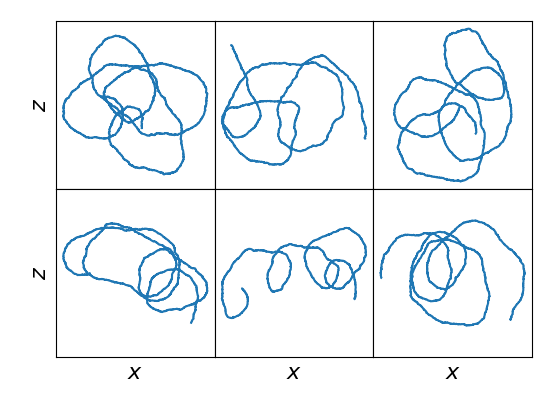

In [8]:
params = SubplotParams(left=0.1, bottom=0.15, hspace=0, wspace=0)
plt.figure(subplotpars=params)

nrows, ncols = 2, 3

for i, r in enumerate(sp_runs):
    with pyh5md.File(r, 'r') as a:
        obs = a['observables']
        sp_pos = pyh5md.element(obs, 'janus_pos').value[::16,::2]

    plt.subplot(nrows, ncols,i+1)
    plt.plot(*sp_pos.T)

    if i%ncols==0:
        plt.ylabel(r'$z$')
    plt.yticks([])

    if i>=ncols*(nrows-1):
        plt.xlabel(r'$x$')
    plt.xticks([])

    x1, x2 = plt.xlim()
    y1, y2 = plt.ylim()
    delta = y2-y1 - (x2-x1)

    if delta>0:
        plt.xlim(x1 - delta/2, x2 + delta/2)
    else:
        plt.ylim(y1 + delta/2, y2 - delta/2)

    if i+1==nrows*ncols:
        break

plt.savefig('L_sp_six_trajectories.pdf')